# Autoencoderサンプル(Pytorch)
作成日2021/05/07


In [56]:
import numpy as np
import csv
import pandas as pd
root_path = "Obrid_AE/test_data/"
test_data_path = root_path + "data0503.csv"
#---------------CSVから読み取る----------------------------
data_df = pd.read_csv(test_data_path, engine="python")
data = data_df.values
#---------------CSVから読み取る----------------------------
print(data.shape)
print(data[0])
#Numpy形式で保存https://note.nkmk.me/python-numpy-load-save-savez-npy-npz/
np.save(root_path + "np_data", data)

(100, 256)
[ 20  24  22  26  24  28  30  24  30  30  32  32  36  34  36  40  36  40
  40  42  42  42  48  50  46  48  50  54  52  54  52  56  54  60  58  58
  56  58  60  60  60  56  58  54  58  58  56  50  52  50  50  48  46  46
  44  44  42  46  40  38  38  34  36  32  32  32  30  30  32  30  32  32
  32  32  30  30  30  32  26  30  30  30  30  28  26  30  30  24  30  32
  30  30  30  32  32  36  32  30  30  30  36  34  34  32  32  34  34  28
  32  34  28  34  38  42  42  44  46  48  50  58  60  64  66  68  72  74
  80  72  80  88  90  90  92  90  94  94  90  90  84  88  84  86  88  84
  84  80  82  82  78  78  74  74  70  66  66  64  64  64  60  56  54  52
  50  46  44  44  38  36  26  26  28  26  22  20  16  14  14  10   6   8
  10  10   8   6   8   6   8   6  10   8  12  10  10  10  10  10  10  10
  12  10   8  12  10  12  12  14  10  16  12  14  14  14  16  16  18  22
  22  22  24  30  30  34  34  38  40  46  48  52  54  42  58  64  68  68
  70  72  76  72  78  80  86  90  88  94

In [64]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
#---------------Numpy形式から読み取る----------------------------
data = np.load(root_path + "np_data" + ".npy")
print(data.max(), data.min())
data = (data - data.min()) / (data.max() - data.min())
#---------------Numpy形式から読み取る----------------------------
#エポック数とエポック自体のサイズ
epoch_num = 100
epoch_size = 84
list=[]
for i in range(epoch_num):
    #ランダムに配列の番号をランダムに指定
    make_epoch = np.random.randint(0, len(data), (epoch_size))
    #ランダムに指定した番号のデータを選択、リストに追加
    list.append(data[make_epoch, :])
test_data = np.array(list)
# conv1を適用するために３次元
test_data = test_data[:, :, np.newaxis, np.newaxis, :]
# test_data = np.array(list)/1024
test_data.shape

428 0


(100, 84, 1, 1, 256)

##  一次元CNN
カーネルのサイズとか色々変えながらやってみてください。
前結合層も組み込もうとしてたけど、あまり具合が良くなさそうだったためコメントアウトしてます。
丸め誤差的なので出力サイズが256にならない現象が起きてるので、output_paddingなど追加した、ここら辺のパラメタを使えば埋め合わせができる

In [65]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        #N(バッチサイズ), 784(ピクセル数64x64)
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5),
            # nn.MaxPool1d(kernel_size=5, stride= 3)
            nn.ReLU(),
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3),
            # nn.ReLU(),
            # nn.Flatten(0, -1),
            # nn.Linear(16, 12), #N,64 -> N,12
            # nn.ReLU(),
            # nn.Linear(12, 3), #N,12 -> N,3
        )
        self.decoder = nn.Sequential(
            # nn.Linear(3, 12), #N,784 -> N,128
            # nn.ReLU(),
            # nn.Linear(12, 16), #N,128 -> N,64
            # nn.ReLU(),
            # nn.Unflatten(0, (1, 1 ,16)),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5, padding = 1, output_padding=1),
            # nn.Flatten(0, -1),
            # nn.ReLU(),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 前結合層あり一次元CNN

In [66]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         #N(バッチサイズ), 784(ピクセル数64x64)
#         self.encoder = nn.Sequential(
#             nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5),
#             # nn.MaxPool1d(kernel_size=5, stride= 3)
#             nn.ReLU(),
#             nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3),
#             nn.ReLU(),
#             nn.Flatten(0, -1),
#             # nn.Linear(16, 12), #N,16 -> N,12
#             # nn.ReLU(),
#             # nn.Linear(12, 3), #N,12 -> N,3\
#             nn.Linear(16, 3), #N,16 -> N,12
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(3,  16),
#             # nn.Linear(3, 12), #N,784 -> N,128
#             # nn.ReLU(),
#             # nn.Linear(12, 16), 
#             nn.ReLU(),
#             nn.Unflatten(0, (1, 1 ,16)),
#             nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5, padding = 1, output_padding=1),
#             # nn.Flatten(0, -1),
#             # nn.ReLU(),
#             nn.Sigmoid(),
#         )
    
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

## 学習

In [67]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
for epoch in test_data:
    for data in epoch:
        recon = model(data)
        print(recon.shape, data.shape)
        loss = criterion(recon, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, data, recon))

orch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1,

, 0.1682, 0.1636, 0.1682,
        0.1682, 0.1729, 0.1729, 0.1776, 0.1822, 0.1822, 0.1869, 0.1776, 0.1869,
        0.1963, 0.1963, 0.1916, 0.1963, 0.1916, 0.2056, 0.1963, 0.2056, 0.2009,
        0.2009, 0.2056, 0.2103, 0.2103, 0.2150, 0.2150, 0.2056, 0.2196, 0.2290,
        0.2196, 0.2196, 0.2290, 0.2243, 0.2290, 0.2383, 0.2290, 0.2336, 0.2290,
        0.2336, 0.2336, 0.2430, 0.2383, 0.2383, 0.2430, 0.2430, 0.2430, 0.2290,
        0.2430, 0.2570, 0.2523, 0.2430, 0.2383, 0.2617, 0.2850, 0.3037, 0.3178,
        0.3224, 0.3318, 0.3551, 0.3645, 0.3832, 0.3925, 0.4019, 0.4159, 0.4252,
        0.4346, 0.4346, 0.4393, 0.4439, 0.4486, 0.4486, 0.4439, 0.4439, 0.4393,
        0.4393, 0.4252, 0.4252, 0.4065, 0.4065, 0.3925, 0.4019, 0.3925, 0.3925,
        0.3879, 0.3785, 0.3832, 0.3832, 0.3785, 0.3738, 0.3645, 0.3645, 0.3598,
        0.3645, 0.3598, 0.3551, 0.3551, 0.3598, 0.3598, 0.3551, 0.3411, 0.3458,
        0.3364, 0.3318, 0.3318, 0.3271, 0.3224, 0.3084, 0.2897, 0.2664, 0.2991,
        0.3084

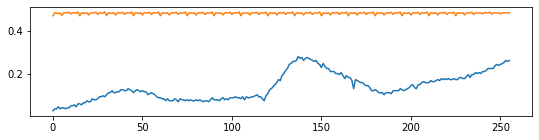

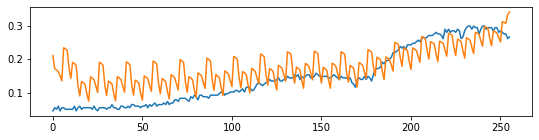

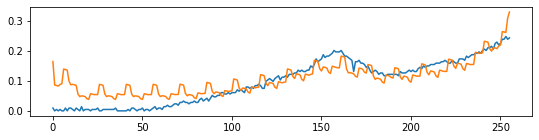

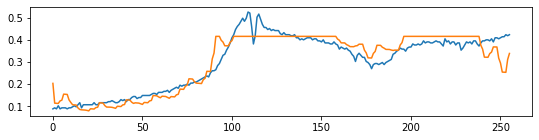

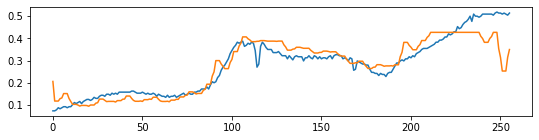

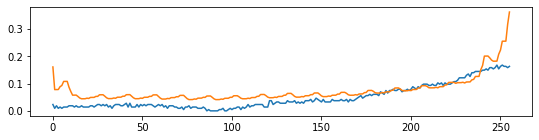

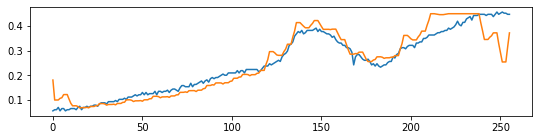

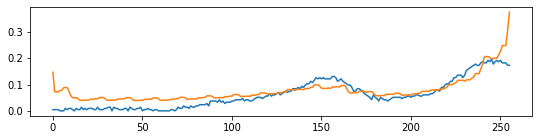

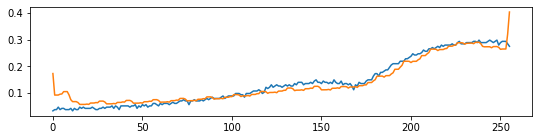

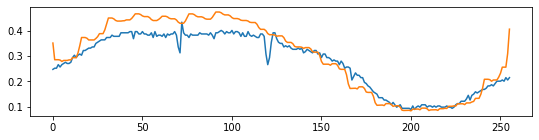

In [68]:
for k in range(0, epoch_num, int(epoch_num/10)):
    plt.figure(figsize=(9, 2))
    datas = outputs[k][1].flatten().detach().numpy()
    recon = outputs[k][2].flatten().detach().numpy()
    print(data.flatten())
    print(recon.flatten())
    plt.plot(datas)
    plt.plot(recon)

## 異常検知

In [69]:
#データの読み込み
test_path = "Obrid_AE/test_data/test0503.csv"
test_df = pd.read_csv(test_path, engine="python").values
# test = test_df.values
# test = test_df.values/1024
test = (test_df - test_df.min()) / (test_df.max() - test_df.min())
print(test.shape)
print(test[0])
data_path = "Obrid_AE/test_data/data0503.csv"
data_df = pd.read_csv(data_path, engine="python").values
# Data = data_df.values
# Data = data_df.values/1024
Data = (data_df - data_df.min()) / (data_df.max() - data_df.min())
print(Data.shape)
print(Data[0])

(50, 256)
[0.01587302 0.02040816 0.01814059 0.02267574 0.01814059 0.01814059
 0.02040816 0.01814059 0.01587302 0.01814059 0.01814059 0.01814059
 0.02040816 0.01587302 0.01814059 0.02040816 0.01587302 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.01814059 0.01814059
 0.01814059 0.01814059 0.01587302 0.01814059 0.02040816 0.01814059
 0.01814059 0.01814059 0.01814059 0.02040816 0.01587302 0.01814059
 0.01587302 0.01360544 0.01814059 0.01587302 0.01587302 0.01814059
 0.01814059 0.01587302 0.01814059 0.01814059 0.01814059 0.01587302
 0.01814059 0.01814059 0.02040816 0.01814059 0.02267574 0.01814059
 0.01814059 0.01587302 0.02040816 0.02494331 0.02040816 0.02267574
 0.02267574 0.02040816 0.02494331 0.02267574 0.02721088 0.02494331
 0.02267574 0.02494331 0.02947846 0.02721088 0.02947846 0.03174603
 0.03174603 0.03401361 0.02947846 0.03174603 0.02721088 0.02947846
 0.02947846 0.03174603 0.03401361 0.03174603 0.03174603 0.03174603
 0.02947846 0.03401361 0.03401361 0.02721088 0.03401

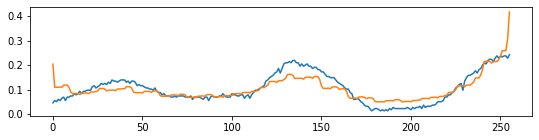

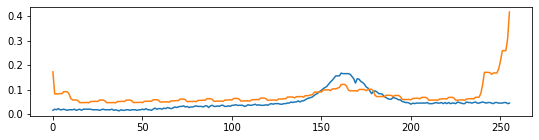

In [70]:
data0 =  torch.from_numpy((Data[0]).astype(np.float32)).clone()
test0 =  torch.from_numpy((test[0]).astype(np.float32)).clone()

plt.figure(figsize=(9, 2))
# data = data0.numpy()
data = data0[np.newaxis, np.newaxis, :]
recon = model(data).detach().numpy()
plt.plot(data0.numpy())
plt.plot(recon.flatten())
plt.show()

plt.figure(figsize=(9, 2))
# data = test0.numpy()
data = test0[np.newaxis, np.newaxis, :]
recon = model(data).detach().numpy()
plt.plot(test0.numpy())
plt.plot(recon.flatten())